# Quantization Modes


In [419]:
# define imports
import numpy as np
from pathlib import Path

from quantization_notes.utils.utils import plot_table

OUTPUT_DIR = Path("../output")

## Symmetric Quantization

In symmetric quantization, we map the floating-point range to the quantized range with respect to $0$ - think along the lines of $[-100,100]$. To do so, we choose $\alpha = \max|x_f| = -\max(x_f)$ and $\max(x_f)$, where $x_f$ is some number in the floating-point range.

Additionally, we choose $N_{bins} = 2^n$, where $n$ is the number of bits we want to quantize to. In order to derive our quantization range with respect to $0$, we simply place half the bins before $0$ and the other half after $0$.

Example: Let's say we wanted an 8-bit quantization range. Then, the number of bins would be $N_{bins} = 2^8 = 256 \implies [0,255] \implies [-128,127]$. That is the "full range" symmetric around 0. However in practice, this range is generally "restricted" to $[-127,127]$. We can derive scaling factors to map from floating point to quantized for both ranges:

$$
\def\arraystretch{1.5}
\begin{array}{c|c|c}
& \text{Full Range} & \text{Restricted Range} \\ \hline
\text{Quantized Range} & [-\frac{N_{bins}}{2},\frac{N_{bins}}{2}-1] & [-(\frac{N_{bins}}{2}-1),\frac{N_{bins}}{2}-1] \\ \hline
\text{8-bit Example} & [-128,127] & [-127,127] \\ \hline
\text{Scale Factor} & q_x=\frac{(2^n-1)/2}{\alpha} & q_x=\frac{2^{n-1}-1}{\alpha} \\
\end {array}
$$

Finally, we can compute our symmetric quantized tensor clamped to our range $[a,b]$:

$$x_q = \text{clamp}(\text{round}(q_xx_f);a;b)$$

**Note**: Clamping is just a fancy way of setting any value outside of the range $[a,b]$ to $a$ or $b$. For example, if we have an interval of $[0,1]$, values smaller than 0 become 0, and values larger than 1 become 1. In reality, this is more of a technique to ensure that quantized values remain in the specific range.


In [420]:
def quantize_symmetric_full(n: int, x_f: np.array) -> tuple[float, np.array]:
    lower_bound = -pow(2, n) / 2
    upper_bound = pow(2, n) / 2 - 1

    q_x = ((pow(2, n) - 1) / 2) / np.max(np.abs(x_f))
    x_q = np.clip(np.round(q_x * x_f), lower_bound, upper_bound)

    return q_x, x_q


def quantize_symmetric_restricted(n: int, x_f: np.array) -> tuple[float, np.array]:
    lower_bound = -(pow(2, n) / 2 - 1)
    upper_bound = pow(2, n) / 2 - 1

    q_x = (pow(2, n - 1) - 1) / np.max(np.abs(x_f))
    x_q = np.clip(np.round(q_x * x_f), lower_bound, upper_bound)
    return q_x, x_q


data = np.random.uniform(-500, 1000, size=(5, 5))
print(f"unquantized data:\n {data} \n")

quantized_symmetric_full_scale, quantized_symmetric_full_data = quantize_symmetric_full(
    8, data
)
print(f"quantized symmetric full\n {quantized_symmetric_full_data} \n")

(
    quantized_symmetric_restricted_scale,
    quantized_symmetric_restricted_data,
) = quantize_symmetric_restricted(8, data)
print(f"quantized symmetric restricted\n {quantized_symmetric_restricted_data} \n")

unquantized data:
 [[ 590.86824869 -135.56078773  740.45055679  137.5265983  -494.88965651]
 [ 420.88664413  690.18544054   26.41720146 -191.97871617  610.15439876]
 [-144.29487252  311.47068378  674.07733774 -170.74708772  864.0170832 ]
 [-444.47308763 -277.62080241  728.54175929 -489.27811983  825.09773447]
 [-413.3863434  -371.42365657  302.09950587  896.96532124  560.43670525]] 

quantized symmetric full
 [[ 84. -19. 105.  20. -70.]
 [ 60.  98.   4. -27.  87.]
 [-21.  44.  96. -24. 123.]
 [-63. -39. 104. -70. 117.]
 [-59. -53.  43. 127.  80.]] 

quantized symmetric restricted
 [[ 84. -19. 105.  19. -70.]
 [ 60.  98.   4. -27.  86.]
 [-20.  44.  95. -24. 122.]
 [-63. -39. 103. -69. 117.]
 [-59. -53.  43. 127.  79.]] 



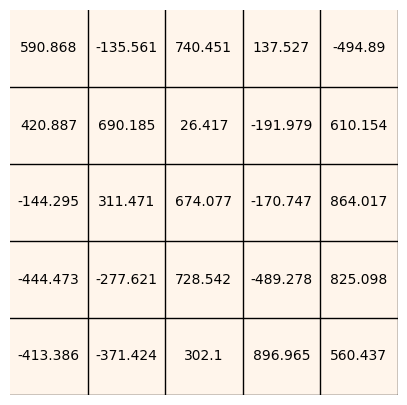

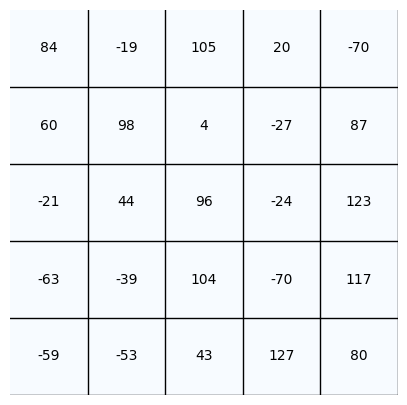

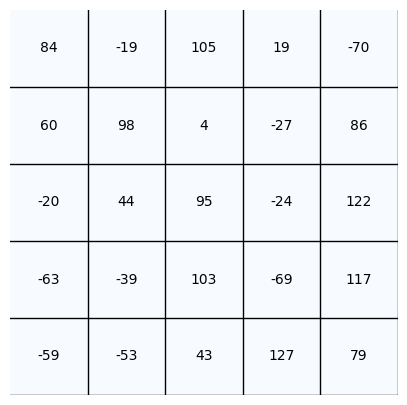

In [421]:
plot_table(data, str(OUTPUT_DIR / "unquantized-data.png"), "Oranges", "black", "black")
plot_table(
    quantized_symmetric_full_data,
    str(OUTPUT_DIR / "quantized-symmetric-full.png"),
    "Blues",
    "black",
    "black",
)
plot_table(
    quantized_symmetric_restricted_data,
    str(OUTPUT_DIR / "quantized-symmetric-restricted.png"),
    "Blues",
    "black",
    "black",
)

## Asymmetric Quantization

Compared to symmetric quantization, asymmetric also known as _affine_ quantization has a few key differences:

- Instead of mapping the floating point range $[-\alpha, \alpha]$ to some quantized range symmetric to $0$, we choose $[\alpha, \beta]$, where $\alpha=\min(x_f)$ and $\beta=\max(x_f)$
- Since the mapping is no longer symmetric to $0$, we have to introduce a **zero-point** $z_{x}$ also known as _quantization bias_. This serves to actually represent $0$ in the quantized range.
- Additionally, the quantized range is now represented by $[0,2^n-1]$.

We can derive a scaling factor for asymmetric quantization:

$$
\def\arraystretch{1.5}
\begin{array}{c|c}
\text{Quantized Range} & [0,2^n-1] \\ \hline
\text{8-bit Example} & [0, 255] \\ \hline
\text{Scale Factor} & q_x=\frac{2^n-1}{\beta-\alpha} \\
\end {array}
$$

To find the zero-point $z_{x}$, simply take the minimum value of $x_f$ i.e. $\alpha$ and scale it to its representation in the new quantized range, which is:

$$
z_x = \text{round}(q_x\alpha)
$$

Finally, we can compute our asymmetric quantized tensor $q_x$ adjusted for bias:

$$
x_q = \text{clamp}(\text{round}(q_xx_f)-z_x;0;2^n-1)
$$


quantized asymmetric 
 [[199.  66. 227. 116.   0.]
 [168. 217.  96.  56. 203.]
 [ 65. 148. 214.  60. 249.]
 [ 10.  40. 224.   1. 242.]
 [ 15.  23. 146. 255. 194.]] 



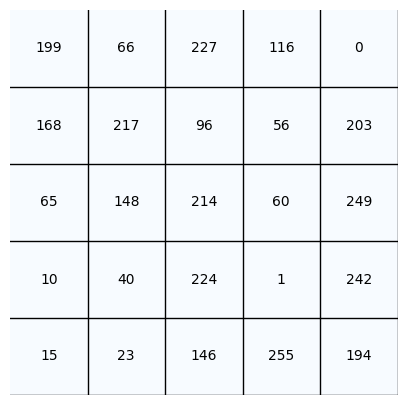

In [422]:
def quantize_asymmetric(n: int, x_f: np.array) -> tuple[float, float, np.array]:
    alpha = np.min(x_f)
    beta = np.max(x_f)
    q_x = (pow(2, n) - 1) / (beta - alpha)
    zero_point = np.round(q_x * alpha)

    x_q = np.clip(np.round(q_x * x_f) - zero_point, 0, pow(2, n) - 1)

    return q_x, zero_point, x_q


(
    quantized_asymmetric_scale,
    quantized_asymmetric_zero_point,
    quantized_asymmetric_data,
) = quantize_asymmetric(8, data)
print(f"quantized asymmetric \n {quantized_asymmetric_data} \n")

plot_table(
    quantized_asymmetric_data,
    str(OUTPUT_DIR / "quantized-asymmetric.png"),
    "Blues",
    "black",
    "black",
)

## Dequantization and Error

Dequantization of a symmetric quantization is as simple as computing the quotient of the quantized tensor $x_q$ and the scale factor $q_x$:

$$\hat{x_f} = \frac{x_q}{q_x}$$

Similarly, dequantization of an asymmetric quantization is as follows adjusting for the zero-point:

$$\hat{x_f} = \frac{x_q+z_x}{q_x}$$

However as expected, there is some error associated with the process of quantizing a tensor and then dequantizing it. We can compute that error using mean-squared error (MSE):

$$
\text{MSE} = \frac{1}{n}\displaystyle\sum(\hat{x_f}-x_f)^2
$$


In [423]:
def dequantize_symmetric(q_x: float, x_q: np.array) -> np.array:
    return x_q / q_x


def dequantize_asymmetric(q_x: float, zero_point: float, x_q: np.array) -> np.array:
    return (x_q + zero_point) / q_x


def mse(a: np.array, b: np.array) -> float:
    return np.mean((a - b) ** 2)


dequantized_symmetric_full_data = dequantize_symmetric(
    quantized_symmetric_full_scale, quantized_symmetric_full_data
)
dequantized_symmetric_full_error = mse(dequantized_symmetric_full_data, data)

print(f"dequantized symmetric full data: \n {dequantized_symmetric_full_data} \n")
print(f"dequantized symmetric full error: \n {dequantized_symmetric_full_error:.2}% \n")

dequantized_symmetric_restricted_data = dequantize_symmetric(
    quantized_symmetric_restricted_scale, quantized_symmetric_restricted_data
)
dequantized_symmetric_restricted_error = mse(
    dequantized_symmetric_restricted_data, data
)

print(
    f"dequantized symmetric restricted data: \n {dequantized_symmetric_restricted_data} \n"
)
print(
    f"dequantized symmetric restricted error: \n {dequantized_symmetric_restricted_error:.2}% \n"
)

dequantized_asymmetric_data = dequantize_asymmetric(
    quantized_asymmetric_scale,
    quantized_asymmetric_zero_point,
    quantized_asymmetric_data,
)
dequantized_asymmetric_error = mse(dequantized_asymmetric_data, data)

print(f"dequantized asymmetric data: \n {dequantized_asymmetric_data} \n")
print(f"dequantized asymmetric error: \n {dequantized_asymmetric_error:.2}% \n")

dequantized symmetric full data: 
 [[ 590.9418587  -133.66542042  738.67732338  140.70044255 -492.45154892]
 [ 422.10132764  689.43216849   28.14008851 -189.94559744  612.04692508]
 [-147.73546468  309.54097361  675.36212423 -168.84053106  865.30772167]
 [-443.20639403 -274.36586297  731.64230125 -492.45154892  823.09758891]
 [-415.06630552 -372.85617275  302.50595148  893.44781018  562.80177019]] 

dequantized symmetric full error: 
 4.7% 

dequantized symmetric restricted data: 
 [[ 593.26840145 -134.19166223  741.58550182  134.19166223 -494.39033454]
 [ 423.76314389  692.14646836   28.25087626 -190.69341475  607.39383958]
 [-141.2543813   310.75963886  670.95831117 -169.50525756  861.65172592]
 [-444.95130109 -275.44604353  727.46006369 -487.32761548  826.33813059]
 [-416.70042483 -374.32411044  303.69691979  896.96532124  557.95480613]] 

dequantized symmetric restricted error: 
 4.4% 

dequantized asymmetric data: 
 [[ 589.49151999 -136.45637037  742.3226548   136.45637037 -496.70